# CS146 Assignment 3

## Using Stan & other exercises

### 1. Implement models in Stan 

#### 1. Call center data set — exponential likelihood with a gamma prior. 

Estimate the number
of calls per minute for the 13th hour of the call center data set.
Results to compute:
  - Posterior 98% confidence interval over λ (check that it matches results in the
solution notebook below)
  - Histogram of posterior λ samples


Resources for you to use:
  - Data set: call_center.csv
  - Solution for class activity (call_center_solution.ipynb)

In [79]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pystan

# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call-center.csv')
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)


    
#chosing the 13th hour

hour_index = 13
waiting_times_13 = waiting_times_per_hour[hour_index]

#Preparing the dataset for Stan.

data = {
                      'waiting_times_13': waiting_times_13, #different values in the waiting time dataset
                      'num_waiting': len(waiting_times_13), #number of each waiting times 
                      #in the class activity we use a gamma distribution with parameters
                      #alpha=1 and beta=0.25 as our prior.
                      'alpha': 1, 
                      'beta': 0.25
                   }


Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [80]:
#stan code for the call center data

stan_codecc = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_waiting; // number of each waiting times 
    real<lower=0> waiting_times_13[num_waiting];  //different values in the waiting time for the 13th hour
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
// We will use the exponential distribution as our likelihood function thus
// The exponential distribution has 1 parameter, namely the rate lambda.
parameters {
    real<lower=0> lambda;  // call rate for the 13th hour
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
// We will use gamma distribution with the fixed prior hyperparameter
model {
  lambda ~ gamma(alpha, beta);  // gamma prior over fixed prior hyperparameter
  waiting_times_13[i] ~ exponential(lambda);  // exponential likelihood function
  }
}

"""


In [81]:
stan_modelcc = pystan.StanModel(model_code=stan_codecc)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cd6628ef69b90758bfa07d3d8e10cc3a NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/g7/bvwq448s61g5r8534tlj1psc0000gn/T/tmpgetinbzq/stanfit4anon_model_cd6628ef69b90758bfa07d3d8e10cc3a_1897147767487673274.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [82]:
# Generate posterior samples

results_callcenter = stan_modelcc.sampling(data=data)
print('\nCall Center the 13th hour results:\n')
print(results_callcenter.stansummary(pars=['lambda'], probs=[0.02, 0.98]))


Call Center the 13th hour results:

Inference for Stan model: anon_model_cd6628ef69b90758bfa07d3d8e10cc3a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd     2%    98%  n_eff   Rhat
lambda   6.34  8.3e-3   0.33   5.71   7.03   1547    1.0

Samples were drawn using NUTS at Sun Oct 20 17:32:14 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 98% interval over lambda [5.73050689 7.04573925]


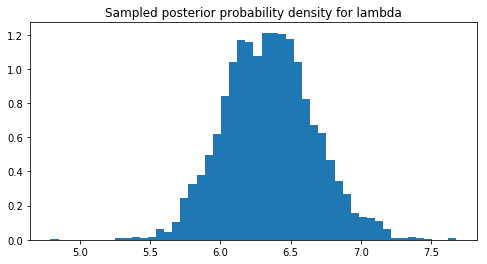

In [84]:
# Generate posterior samples

samples_callcenter = results_callcenter.extract()

#Posterior 98% confidence interval over λ

print('Posterior 98% interval over lambda', np.percentile(samples_callcenter['lambda'], [2, 98]))

# Histogram of posterior λ samples

plt.figure(figsize=(8,4))
plt.hist(samples_callcenter['lambda'], bins=50, density=True)
plt.title('Sampled posterior probability density for lambda')
plt.show()


#### Review

In the class activity the results were: "Posterior 98% confidence interval over λ: [5.6, 7.1]". Since there is only a small difference between the results (which is due to how each programm expressed different decimals), we can conclude that the method is successfull.

#### 2. Normal likelihood with normal-inverse-gamma prior.

Results to compute:
- 95% posterior confidence intervals for the mean μ and variance σ of the data.
2
- Take 10 samples from your posterior over μ and σ and plot the normal
2 distributions corresponding to them. See Task 3 in the solutions below — you should
produce a plot similar to the one you find there.


Resources for you to use:
- Data and solution for class activity (normal_inverse_gamma_solution.ipynb)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Defining the data set

dataset = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(dataset), "data points")
print(min(dataset), "minimum value")

#Preparing the dataset for Stan.

datanormal = {
                    'dataset': dataset,
                    'num_data': len(dataset),
                    # The values of mu, nu, alpha and beta was given in the pre-class work
                    # The prior mean is centered around 0.
                    'mu': 0,
                    # The smaller nu is, the more uncertain we are about the prior mean.
                    'nu': 0.054, 
                    # alpha and beta govern the marginal prior over the variance.
                    'alpha': 1.12,  
                    'beta': 0.4
                  }



200 data points
-1.90805399279409 minimum value


In [85]:
#stan code for normal likelihood with normal-inverse-gamma prior.


stan_codenormal = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_data; // length of the data
    real dataset[num_data];  //datapoints (no upper or lower because the min is bellow 0)
    real<lower=0> mu;   // fixed prior hyperparameter
    real<lower=0> nu;   // fixed prior hyperparameter
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
// We will use the normal-inverse-gamma distribution as our likelihood function thus
// we will have 2 parameters as post_mu and sigma2.
parameters {
    real post_mu; 
    real<lower=0> sigma2;
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
// We will use gamma distribution with the fixed prior hyperparameter
model {
    
    sigma2 ~ inv_gamma(alpha, beta);
    post_mu ~ normal(mu, sqrt(sigma2/nu));
    for(i in 1:num_data) {
        dataset[i] ~ normal(post_mu, sqrt(sigma2));  // normal-inverse-gamma likelihood function
  }
}

"""


In [86]:
stan_modelnormal = pystan.StanModel(model_code=stan_codenormal)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52e4cd602e0a105cc6db20ce14de1c73 NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/g7/bvwq448s61g5r8534tlj1psc0000gn/T/tmp_dimh98b/stanfit4anon_model_52e4cd602e0a105cc6db20ce14de1c73_2374131106772405378.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [87]:
results_normal = stan_modelnormal.sampling(data=datanormal)

print('\nResults:\n')
print(results_normal.stansummary(pars=['post_mu', 'sigma2'], probs=[0.05, 0.95]))



Results:

Inference for Stan model: anon_model_52e4cd602e0a105cc6db20ce14de1c73.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd     5%    95%  n_eff   Rhat
post_mu   3.06  2.3e-3   0.13   2.84   3.28   3400    1.0
sigma2    3.62  6.2e-3   0.36   3.08   4.26   3442    1.0

Samples were drawn using NUTS at Sun Oct 20 18:06:22 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% interval for the mean μ of the data [2.84026314 3.2816424 ]
Posterior 95% interval for the variance σ of the data [3.08256657 4.26064931]


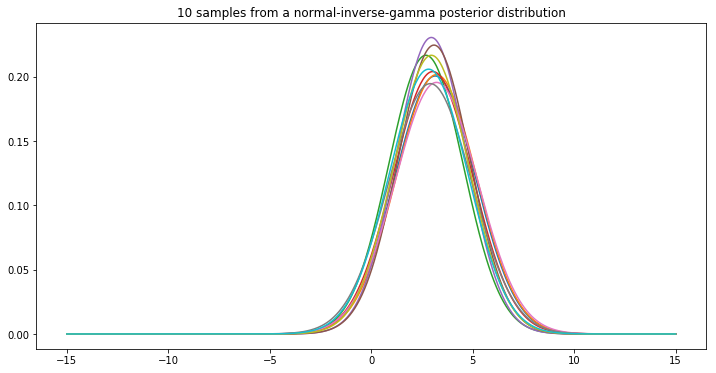

In [88]:
#95% posterior confidence intervals for the mean μ and variance σ of the data.
samples_normal = results_normal.extract()
print('Posterior 95% interval for the mean μ of the data', np.percentile(samples_normal['post_mu'], [5, 95]))
print('Posterior 95% interval for the variance σ of the data', np.percentile(samples_normal['sigma2'], [5, 95]))

# Take 10 samples from your posterior over μ and σ and plot the normal 2 distributions corresponding to them
samples_mu = np.random.choice(samples_normal['post_mu'], 10)
samples_sigma2 = np.random.choice(samples_normal['sigma2'], 10)

# Plot  the samples
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(10):
    plot_y = stats.norm.pdf(plot_x, loc=samples_mu[i], scale=np.sqrt(samples_sigma2[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % 10)
plt.show()


#### Review

The results in class:

x: [2.800, 3.328]
σ²: [2.975, 4.396]

Same as previous example there is only a small difference between the results that is probably due to decimal calculations. The graphs match almost perfectly with the result from the class.


#### 3. Log-normal HRTEM data

Normal likelihood log-transformed data and using a
normal-inverse-gamma prior.
Results to compute:
- 95% posterior confidence intervals for the μ and variance σ of the log-transformed
2
data. (Should match results under Task 3 of the solutions.)
- Take 10 samples from your posterior over μ and σ and plot the log-normal
2
distributions corresponding to them. See Task 5 in the solutions below — you should
produce a plot similar the one you find there, but with 10 pdfs rather than one.


Resources for you to use:
- Data set: hrtem.csv (remember to log-transform the data)
- Solution for class activity (hrtem_solution.ipynb)

In [89]:
# Load data: read the particle sizes (in nanometers) from a CSV file.
data = np.loadtxt('hrtem.csv')
print('%i data, min: %f, max: %f' % (len(data), min(data), max(data)))

#Transform the data to log
logdata = np.log(data)
print('%i log data, min: %f, max: %f' % (len(logdata), min(logdata), max(logdata)))


datahrtem = {
                'logdata': logdata, #data points
                'num_data': len(logdata), #length of the dataset
                #Based on the pre-class work - our prior hyperparameters.
                'mu': 2.3,
                'nu': 0.1,
                'alpha': 2,
                'beta': 5
}

500 data, min: 1.051827, max: 28.942578
500 log data, min: 0.050529, max: 3.365314


In [90]:
#stan code for lognormal likelihood with normal-inverse-gamma prior.

stan_codehrtem = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_data; // length of the data
    real logdata[num_data];  //datapoints 
    real<lower=0> mu;   // fixed prior hyperparameter
    real<lower=0> nu;   // fixed prior hyperparameter
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
// We will use the normal-inverse-gamma distribution as our likelihood function thus
// we will have 2 parameters as post_mu and sigma2.
parameters {
    real post_mu; 
    real<lower=0> sigma2;
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
// We will use gamma distribution with the fixed prior hyperparameter
model {
    
    sigma2 ~ inv_gamma(alpha, beta);
    post_mu ~ normal(mu, sqrt(sigma2/nu));
    for(i in 1:num_data) {
        logdata[i] ~ normal(post_mu, sqrt(sigma2));  // normal-inverse-gamma likelihood function
  }
}

"""


In [91]:
stan_modelhrtem = pystan.StanModel(model_code=stan_codehrtem)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fc4afec885da2aee99210185b1840d54 NOW.
/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/g7/bvwq448s61g5r8534tlj1psc0000gn/T/tmpimdcb9v4/stanfit4anon_model_fc4afec885da2aee99210185b1840d54_3396914852312271753.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [92]:
results_hrtem = stan_modelhrtem.sampling(data=datahrtem)

print('\nResults:\n')
print(results_hrtem.stansummary(pars=['post_mu', 'sigma2'], probs=[0.05, 0.95]))




Results:

Inference for Stan model: anon_model_fc4afec885da2aee99210185b1840d54.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd     5%    95%  n_eff   Rhat
post_mu   1.89  5.0e-4   0.03   1.84   1.94   4000    1.0
sigma2     0.5  5.6e-4   0.03   0.45   0.55   3261    1.0

Samples were drawn using NUTS at Sun Oct 20 18:11:01 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 95% interval for the mean μ of the log-transformed data [1.84080509 1.94375239]
Posterior 95% interval for the variance σ of the log-transformed data [0.44565594 0.54942471]


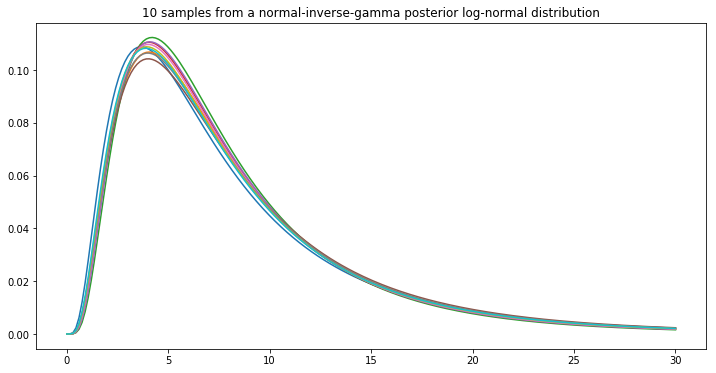

In [93]:
#95% posterior confidence intervals for the μ and variance σ of the log-transformed 2 data. 
samples_hrtem = results_hrtem.extract()
print('Posterior 95% interval for the mean μ of the log-transformed data', 
      np.percentile(samples_hrtem['post_mu'], [5, 95]))
print('Posterior 95% interval for the variance σ of the log-transformed data',
      np.percentile(samples_hrtem['sigma2'], [5, 95]))

# Take 10 samples from your posterior over μ and σ and plot the  log-normal 2 
#distributions corresponding to them
samples_mu_hrtem = np.random.choice(samples_hrtem['post_mu'], 10)
samples_sigma2_hrtem = np.random.choice(samples_hrtem['sigma2'], 10)

# Plot  the samples

plt.figure(figsize=(12,6))
plot_x = np.linspace(0, 30, 200)
for i in range(10):
    plot_y = stats.lognorm.pdf(plot_x, np.sqrt(samples_sigma2_hrtem[i]),
                               scale=np.exp(samples_mu_hrtem[i]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior log-normal distribution' % 10)
plt.show()


#### Review

Class results:

- Mean 95% confidence interval: [1.83, 1.95]
- Variance 95% confidence interval: [0.44, 0.56]

Same as above, they are close enough. Also the graph matches with the graph in task 5. 